In [1]:
# Pytorch modules
import torch
# main class used for making neural networks
from torch import nn
# pytorch has all the datasets I need already in its computer vision module
from torchvision import datasets
# used to parallelize loading (my laptop has only 4 cores)
from torch.utils.data import DataLoader
# used to transform input data into desired format
from torchvision import transforms

# general python modules
import os
import numpy as np
from matplotlib import pyplot as plt

print('all modules imported!')

all modules imported!


In [19]:
# define transformations we will apply to images before using them
transform = transforms.Compose([
    # same size all (MNIST images 28x28)
    transforms.Resize([28,28]),
    # transform to tensor representation
    transforms.ToTensor(),
    # transform to greyscale
    transforms.Grayscale()])

# get the EMNIST (letters and digits) data and apply our transform to it and save to same directory
# train = True by default
emnist = datasets.EMNIST(root='.', # same directory
                         split = 'balanced', #balanced number of labels for each category 
                       download=True, # if already downloaded won't do anything
                       transform = transform)
print(
emnist.data.shape,
emnist.data.max(),
emnist.data.min())

torch.Size([112800, 28, 28]) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


In [25]:
print(dir(emnist))

symbol_map = emnist.class_to_idx

# only letters which look different as uppercase/lowercase have separate label for lowercase
print(symbol_map)
print(len(symbol_map)) # 47 classesb

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_all_classes', '_check_exists', '_check_legacy_exist', '_file_prefix', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_merged_classes', '_repr_indent', '_test_file', '_training_file', 'class_to_idx', 'classes', 'classes_split_dict', 'data', 'download', 'extra_repr', 'images_file', 'labels_file', 'md5', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'split', 'splits', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'tr

In [20]:
# iterator of the dataset (always returns the n = batch size of 
# images with labels in each iteration)
dataloader = DataLoader(dataset = emnist, 
                        batch_size = 64,
                        num_workers = 4) # 4 cpu cores on my laptop

image, label = next(iter(dataloader))

print('One batch:', image.shape)
print(type(image))

One batch: torch.Size([64, 1, 28, 28])
<class 'torch.Tensor'>


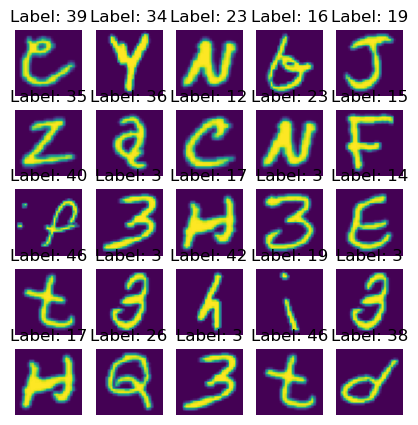

In [22]:
from numpy.random import randint
fig, axes = plt.subplots(5,5,figsize = (5,5))
axes = axes.flatten()
for ax, image_eg in enumerate(randint(0,64,size = 25)):
    # EMNIST dataset is flipped, need to correct ALSO IN TRAINING!!!
    img = image[image_eg]
    img = transforms.functional.rotate(img, -90)
    img = transforms.functional.hflip(img)
    axes[ax].set_title(f'Label: {label[image_eg]}')
    axes[ax].axis('off')
    axes[ax].imshow(img.reshape((28,28)))

# Example data
plt.show()

In [29]:
# fully connected (fc) block (will repeat for multiple hidden layers)
def fc_block(input_size:int,
            output_size:int,
            activation_function:object):
    return nn.Sequential(
        # how to perform "weighed sum" on 'output' of previous layer
        nn.Linear(input_size,output_size),
        # what to do with "weighed sum"
        activation_function())
    
# start with fully connected network
class My_First_NN (nn.Module):
    def __init__(self,
                 in_channels:int,
                 hidden_layers_sizes:list,
                 out_channels:int,
                activation:object):
        # initialize whatever is in __init__ of nn.Module
        super(My_First_NN, self).__init__()
        # this one way how input & hidden layers can be defined
        # sizes (number of nodes) of each layer
        layer_sizes = [in_channels,*hidden_layers_sizes]
        # make blocks of fully connected layers 
        fully_connected_blocks = [fc_block(in_n, out_n, activation)
                                  for in_n, out_n in zip(layer_sizes, layer_sizes[1:])]
        # these will be sequentially executed in the forward pass
        self.layers = nn.Sequential(*fully_connected_blocks,
                                    # for output layer only want weighed sum
                                    nn.Linear(layer_sizes[-1],out_channels))
        
    def forward(self, x):
        # flatten input
        x = x.view(x.size(0),-1)
        # forward pass of input through network
        x = self.layers(x)
        # at the end, x is a list of 10 numbers from 0-10 telling us
        # which label the model predicts
        return x

first_model = My_First_NN(784,
                          [500,250,125],
                          47, # emnist has 47 nodes in output layer
                         nn.ReLU)
# inspect model architecture
print(first_model) # yes, as intended

My_First_NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=250, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=250, out_features=125, bias=True)
      (1): ReLU()
    )
    (3): Linear(in_features=125, out_features=47, bias=True)
  )
)


In [24]:
# training loop
def train_network (network:nn.Module,
                   data_loader:torch.utils.data.DataLoader,
                   epochs:int,
                   # these seem to be popular, beyond me why exactly
                   loss_function:nn.Module = nn.CrossEntropyLoss(),
                   # smaller so that model won't overfit
                   learning_rate:float = 0.001,
                   # here I found SDG and Adam as some popular options
                   optimizer:torch.optim.Optimizer = torch.optim.Adam):
    # set NN in training mode
    network.train(True)

    # set up optimizer
    optimizer = optimizer(network.parameters(), lr = learning_rate)
    # go through epochs
    for epoch in range(epochs):
        # load a batch of training data for given epoch
        for b,batch in enumerate(data_loader):
            samples, labels = batch[0], batch[1]

            # EMNIST dataset is flipped, need to correct ALSO IN TRAINING!!!
            samples = transforms.functional.rotate(samples, -90)
            samples = transforms.functional.hflip(samples)

            # reset gradient, need to calculate gradient afresh every time
            optimizer.zero_grad()
            # run input data through network (somehow this works without calling forward methods)
            predictions = network(samples) #/255 MAYBE NOT normalize to 0-1 todo: find better place to do this
            # calculate eror
            error = loss_function(predictions, labels)
            # calculate gradient
            error.backward()
            # update weights by stepping down the gradient by learning rate sized step
            optimizer.step()
            print(epoch,b, 'done')

# let's train, see how long it takes
train_network(network=first_model,
             data_loader=dataloader,
             epochs = 10)# tried 5, 7 and 10 epochs; then tried 100 epochs to prevent overfitting

print("Training Finished")

0 0 done
0 1 done
0 2 done
0 3 done
0 4 done
0 5 done
0 6 done
0 7 done
0 8 done
0 9 done
0 10 done
0 11 done
0 12 done
0 13 done
0 14 done
0 15 done
0 16 done
0 17 done
0 18 done
0 19 done
0 20 done
0 21 done
0 22 done
0 23 done
0 24 done
0 25 done
0 26 done
0 27 done
0 28 done
0 29 done
0 30 done
0 31 done
0 32 done
0 33 done
0 34 done
0 35 done
0 36 done
0 37 done
0 38 done
0 39 done
0 40 done
0 41 done
0 42 done
0 43 done
0 44 done
0 45 done
0 46 done
0 47 done
0 48 done
0 49 done
0 50 done
0 51 done
0 52 done
0 53 done
0 54 done
0 55 done
0 56 done
0 57 done
0 58 done
0 59 done
0 60 done
0 61 done
0 62 done
0 63 done
0 64 done
0 65 done
0 66 done
0 67 done
0 68 done
0 69 done
0 70 done
0 71 done
0 72 done
0 73 done
0 74 done
0 75 done
0 76 done
0 77 done
0 78 done
0 79 done
0 80 done
0 81 done
0 82 done
0 83 done
0 84 done
0 85 done
0 86 done
0 87 done
0 88 done
0 89 done
0 90 done
0 91 done
0 92 done
0 93 done
0 94 done
0 95 done
0 96 done
0 97 done
0 98 done
0 99 done
0 100 done

In [31]:
# testing loop
def test_performance (loader:torch.utils.data.DataLoader,
                      network:nn.Module,
                      print_which_correct:bool = False):
    # overall performance
    ncorrect, nclassification = 0,0

    # set model into testing mode
    network.eval()
    # context manager disables gradient calculation (only evaluation, doesn't change weights)
    with torch.no_grad():
        for images, labels in loader:
            outputs = network(images)
            # get the index at which the maximum probability occured (reduce over columns = dimension 1{dimension 0 is rows})
            predictions = torch.argmax(outputs,1)
            # makes a mask of True & False, summing over true gives number correct since True = 1
            ncorrect += sum(predictions == labels)
            nclassification += len(predictions)
            if print_which_correct == True:
                print(predictions == labels, labels)
                    
    performance = float(ncorrect)/float(nclassification)
    print(f'{ncorrect} / {nclassification} samples correct -> accuracy {performance*100:.2f} %')
    return performance
          
# test on training data
training_data_performance = test_performance(dataloader,
                                             first_model)

2634 / 112800 samples correct -> accuracy 2.34 %


In [30]:
# testing on testing (unseen data)
test_emnist = datasets.EMNIST(root='.', # same directory
                                download=True, # if already downloaded won't do anything
                                transform = transform,
                                split = 'balanced',
                                # testing part of dataset
                                train = False)

testloader = DataLoader(dataset = test_emnist, 
                        batch_size = 64,
                        num_workers = 4) # 4 cpu cores on my laptop

testing_performance = test_performance(loader = testloader,
                                     network = first_model)

# save model with performance as part of name to current dir
# current dir
path = os.getcwd()
# file path
file_path = os.path.join(path, "emnist_models", f'emnist_model_{testing_performance}.pt')

# everything we want about a model (weights and biases obtained through training) model.in state_dict
torch.save(first_model.state_dict(), file_path)

print('model saved')

466 / 18800 samples correct -> accuracy 2.48 %
model saved


with simplest model architecture (20,30,20) poor performance on EMNIST (7.5%) - need different model architecture?